## Partie 1 : Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Chargement des données

data = pd.read_csv("data_nettoyees.csv", low_memory=False)
data_wo = pd.read_csv("data_wo.csv", low_memory=False)

<IPython.core.display.Javascript object>

In [3]:
## Maintenant que nous avons récupéré les données nettoyées, nous allons effectuer quelques opérations avant de passer aux
## algorithmes. Nous allons donc appliquer la fonction OneHotEncoder à nos variables qualitatives. Dans un premier temps, je vais
## me servir des données sans les outliers et sans la données de EnergySTAR. Ces transformations concernent les données que
## nous allons mettre dans notre algorithme. Les targets seront étudiées dans une deuxième partie.

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


enc = OneHotEncoder(handle_unknown="ignore")

columns = [
    "NumberofBuildings",
    "NumberofFloors",
    "GFABuilding",
    "GFAParking",
    "BuildingAge",
    "PropertyGFATotal",
]
mycolumns = [
    "BuildingType",
    "Neighborhood",
    "LargestPropertyUseType",
    "PrimaryPropertyType",
]

X = data.loc[:, mycolumns]
enc.fit(X)
enc.transform(X)
enc.categories_
X_bis = enc.transform(X).todense()

f1_vec = data.loc[:, columns].values
X_2 = np.concatenate((f1_vec, X_bis), axis=1)

donnees = ["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]

y = data.loc[:, donnees]

<IPython.core.display.Javascript object>

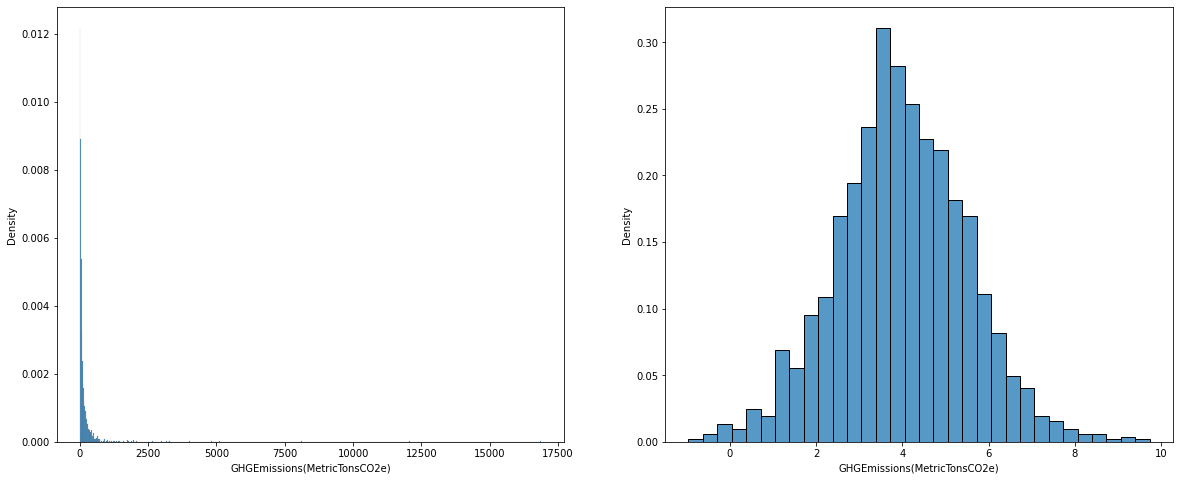

<IPython.core.display.Javascript object>

In [5]:
## Nous allons maintenant modifier nos données à prédire en appliquant une transformation logarithmique à nos variables. On peut remarquer
## qu'en faisant cela, nos variables ont une distribution normale.

from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func=np.exp, check_inverse=True)
Y_log = logtransformer.transform(y)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.histplot(data=y, x="GHGEmissions(MetricTonsCO2e)", stat="density", ax=axes[0])
sns.histplot(data=Y_log, x="GHGEmissions(MetricTonsCO2e)", stat="density", ax=axes[1])
plt.show()

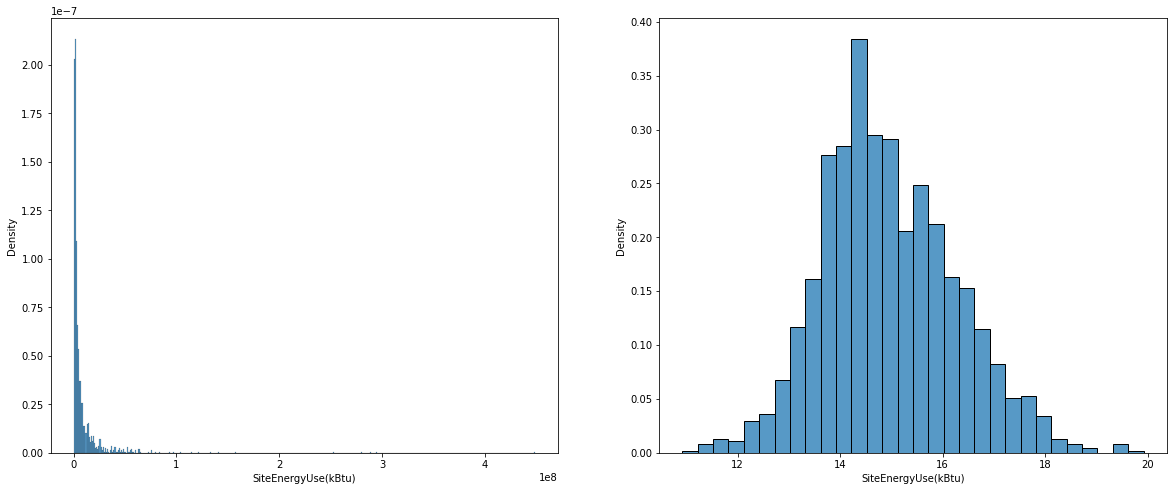

<IPython.core.display.Javascript object>

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.histplot(data=y, x="SiteEnergyUse(kBtu)", stat="density", ax=axes[0])
sns.histplot(data=Y_log, x="SiteEnergyUse(kBtu)", stat="density", ax=axes[1])
plt.show()

In [7]:
## Séparons maintenant nos données entre les variables de tests et d'entrainements. J'ai choisi 80% d'entrainements et 20% de tests

X_train, X_test, y_train, y_test = train_test_split(
    X_2, Y_log, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

## Partie 2 : Modéles linéaires

In [8]:
## Nous allons maintenant passer à la partie où l'on teste les différents modéles.
## Effectons dans un premier temps la régression Ridge
## Pour pouvoir comparé les modéles, je vais enregistrer le R2, le MAE et le temps.

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

ridge = Ridge()

pipe_ridge = Pipeline([("scaler", StandardScaler()), ("Ridge", ridge)])

n_alphas = 200
alphas = np.logspace(2, 3, n_alphas)
param_grid = dict(Ridge__alpha=alphas)

# Modéle pour l'énergie

grid = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)
grid_result = grid.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

Ridge_Energy = grid.best_estimator_

Energy_results_ridge = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(
        Energy_results_ridge[Energy_results_ridge.rank_test_r2 == 1]["mean_test_r2"]
    ),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_ridge[Energy_results_ridge.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(
        Energy_results_ridge[Energy_results_ridge.rank_test_r2 == 1]["mean_fit_time"]
    ),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best R2:  [0.58000103]
Best MAE:  [-0.65536748]
Temps moyen [0.00639858] s
Best Params:  {'Ridge__alpha': 112.26677735108136}


<IPython.core.display.Javascript object>

In [9]:
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('Ridge', ridge)])

n_alphas = 200
alphas = np.logspace(2,3,n_alphas)

param_grid = dict(Ridge__alpha=alphas)

## Modéle pour les émissions de CO2

grid = GridSearchCV(pipe_ridge, param_grid=param_grid, cv = 5, scoring=('r2','neg_mean_absolute_error'), return_train_score = True,refit='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

Ridge_CO2 = grid.best_estimator_

CO2_results_ridge = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(CO2_results_ridge[CO2_results_ridge.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(CO2_results_ridge[CO2_results_ridge.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(CO2_results_ridge[CO2_results_ridge.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best R2:  [0.42513401]
Best MAE:  [-0.88492608]
Temps moyen [0.01040068] s
Best Params:  {'Ridge__alpha': 176.2914118095948}


<IPython.core.display.Javascript object>

In [10]:
## Maintenant, nous allons effectuer la régression Lasso

from sklearn.linear_model import Lasso

lasso = Lasso()

pipe_lasso = Pipeline([('scaler', StandardScaler()), ('Lasso', lasso)])

n_alphas = 200

alphas = np.logspace(-2,-1,n_alphas)

param_grid = dict(Lasso__alpha=alphas)

## Modéle pour l'énergie

grid = GridSearchCV(pipe_lasso, param_grid=param_grid, cv = 5,scoring=('r2','neg_mean_absolute_error'),return_train_score = True,refit='r2', verbose=1, n_jobs=-1)

grid_result = grid.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

Lasso_Energy = grid.best_estimator_

Energy_results_lasso = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(Energy_results_lasso[Energy_results_lasso.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(Energy_results_lasso[Energy_results_lasso.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(Energy_results_lasso[Energy_results_lasso.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best R2:  [0.59019945]
Best MAE:  [-0.64995872]
Temps moyen [0.02046227] s
Best Params:  {'Lasso__alpha': 0.01933891750455231}


<IPython.core.display.Javascript object>

In [11]:
pipe_lasso = Pipeline([("scaler", StandardScaler()), ("Lasso", lasso)])

n_alphas = 200

alphas = np.logspace(-2, -1, n_alphas)

param_grid = dict(Lasso__alpha=alphas)

## Modéle pour les émissions de CO2

grid = GridSearchCV(
    pipe_lasso,
    param_grid=param_grid,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error"),
    refit="r2",
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
)

grid_result = grid.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])

Lasso_CO2 = grid.best_estimator_

CO2_results_lasso = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(CO2_results_lasso[CO2_results_lasso.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        CO2_results_lasso[CO2_results_lasso.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(CO2_results_lasso[CO2_results_lasso.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best R2:  [0.43644238]
Best MAE:  [-0.87852561]
Temps moyen [0.01858025] s
Best Params:  {'Lasso__alpha': 0.024658110758226038}


<IPython.core.display.Javascript object>

In [12]:
## Nous allons tester la régression ElasticNet

from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()
pipe_elastic = Pipeline([("scaler", StandardScaler()), ("Elastic", elastic_net)])

n_alphas = 25

alpha = np.logspace(-2, -1, n_alphas)
l1_ratio = np.logspace(0, 1, n_alphas)
param_grid = dict(Elastic__alpha=alpha, Elastic__l1_ratio=l1_ratio)

##  Modéle pour l'énergie

grid = GridSearchCV(
    pipe_elastic,
    param_grid=param_grid,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)
grid_result = grid.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

Elastic_Energy = grid.best_estimator_

Energy_results_Elastic = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(
        Energy_results_Elastic[Energy_results_Elastic.rank_test_r2 == 1]["mean_test_r2"]
    ),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_Elastic[Energy_results_Elastic.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(
        Energy_results_Elastic[Energy_results_Elastic.rank_test_r2 == 1][
            "mean_fit_time"
        ]
    ),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best R2:  [0.59019837]
Best MAE:  [-0.650018]
Temps moyen [0.01198583] s
Best Params:  {'Elastic__alpha': 0.019573417814876596, 'Elastic__l1_ratio': 1.0}


C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58693179        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.58772423        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.58843237        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.589066

<IPython.core.display.Javascript object>

In [13]:
pipe_elastic = Pipeline([('scaler', StandardScaler()), ('Elastic', elastic_net)])

n_alphas = 25

alpha = np.logspace(-2, -1, n_alphas)
l1_ratio = np.logspace(-1,1,n_alphas)
param_grid = dict(Elastic__alpha=alpha, Elastic__l1_ratio=l1_ratio)

## Modéle pour les émissions de CO2

grid = GridSearchCV(pipe_elastic, param_grid=param_grid, cv = 5, scoring=('r2','neg_mean_absolute_error'),refit='r2',return_train_score = True,verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

Elastic_CO2 = grid.best_estimator_

CO2_results_Elastic = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(CO2_results_Elastic[CO2_results_Elastic.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(CO2_results_Elastic[CO2_results_Elastic.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(CO2_results_Elastic[CO2_results_Elastic.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best R2:  [0.43791847]
Best MAE:  [-0.87704931]
Temps moyen [0.01559124] s
Best Params:  {'Elastic__alpha': 0.06812920690579612, 'Elastic__l1_ratio': 0.31622776601683794}


C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.42061458 0.4209398  0.42131681 0.42174437 0.42222195 0.42275146
 0.42336249 0.42410607 0.4250247  0.42610735 0.42731486 0.42857454
 0.4292931         nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.42089593 0.42124582 0.42164202 0.4220953  0.4225924
 0.42316324 0.42383406 0.42468425 0.42566291 0.42678252 0.42807579
 0.42933533 0.43015975        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.42119882 0.4215662  0.42198711 0.42245818
 0.42299177 0.42359634 0.4243576  0.42526257 0.42630574 0.4274932
 0.42882928 0.43010876 0.43112761        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.42151462

<IPython.core.display.Javascript object>

In [14]:
## Testons cette fois-ci une SVR. Après avoir effectué plusieurs tests sur les différents noyaux. Les meilleures performances
## sont avec un noyau Linéaire

from sklearn.svm import LinearSVR

svr = LinearSVR()
pipe_svr = Pipeline([("scaler", StandardScaler()), ("svr", svr)])

n_alphas = 25

C = np.logspace(0, 1, n_alphas)
epsilon = np.logspace(-1, 0, n_alphas)
param_grid = dict(svr__C=C, svr__epsilon=epsilon)

## Modéle pour l'énergie

grid = GridSearchCV(
    pipe_svr,
    param_grid=param_grid,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    refit="r2",
    cv=5,
    verbose=1,
    n_jobs=-1,
)
grid_result = grid.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

SVR_Energy = grid.best_estimator_

Energy_results_svr = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(Energy_results_svr[Energy_results_svr.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_svr[Energy_results_svr.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(Energy_results_svr[Energy_results_svr.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best R2:  [0.57291197]
Best MAE:  [-0.65461628]
Temps moyen [0.48542886] s
Best Params:  {'svr__C': 2.154434690031884, 'svr__epsilon': 0.34807005884284103}


C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<IPython.core.display.Javascript object>

In [15]:
pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])

n_alphas = 25

C = np.logspace(-1, 0, n_alphas )
epsilon = np.logspace(-1,0,n_alphas)
param_grid = dict(svr__C=C, svr__epsilon=epsilon)

## Modéle pour les émissions de CO2

grid = GridSearchCV(pipe_svr, param_grid=param_grid, scoring=('r2','neg_mean_absolute_error'),return_train_score = True,refit='r2', cv = 5, verbose=1,n_jobs=-1)
grid_result = grid.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

SVR_CO2 = grid.best_estimator_

CO2_results_svr = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(CO2_results_svr[CO2_results_svr.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(CO2_results_svr[CO2_results_svr.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(CO2_results_svr[CO2_results_svr.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Best R2:  [0.41230331]
Best MAE:  [-0.89192081]
Temps moyen [0.2012135] s
Best Params:  {'svr__C': 0.34807005884284103, 'svr__epsilon': 0.34807005884284103}


C:\Users\antoi\miniconda3\envs\Test\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<IPython.core.display.Javascript object>

## Partie 3 : Modéles non linéaires

In [16]:
## Testons dans un premier temps le modéle RandomForest

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

pipe_rfr = Pipeline([("scaler", StandardScaler()), ("rfr", rfr)])

param_rfr = {
    "rfr__n_estimators": [50, 100, 250, 400],
    "rfr__max_depth": [1, 10, 25, 30],
    "rfr__min_samples_split": [2, 5, 20, 25],
    "rfr__min_samples_leaf": [1, 5, 10],
}

## Modéle pour l'énergie

grid = GridSearchCV(
    pipe_rfr,
    param_grid=param_rfr,
    cv=5,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)
grid_result = grid.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

RFR_Energy = grid.best_estimator_

Energy_results_rfr = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(Energy_results_rfr[Energy_results_rfr.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_rfr[Energy_results_rfr.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(Energy_results_rfr[Energy_results_rfr.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best R2:  [0.72388194]
Best MAE:  [-0.51902537]
Temps moyen [0.34891396] s
Best Params:  {'rfr__max_depth': 25, 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 25, 'rfr__n_estimators': 50}


<IPython.core.display.Javascript object>

In [17]:
pipe_rfr = Pipeline([('scaler', StandardScaler()), ('rfr', rfr)])

param_rfr = {'rfr__n_estimators' : [50,100,250,300],
             'rfr__max_depth' : [1, 20,30],
            'rfr__min_samples_split' : [2, 10, 15, 20], 
             'rfr__min_samples_leaf' : [1, 5, 10]}

## Modéle pour les émissions de CO2

grid = GridSearchCV(pipe_rfr, param_grid=param_rfr, cv= 5, scoring=('r2','neg_mean_absolute_error'),return_train_score = True, refit='r2',verbose=1,n_jobs=-1)
grid_result = grid.fit(X_train, y_train['GHGEmissions(MetricTonsCO2e)'])

RFR_CO2 = grid.best_estimator_

CO2_results_rfr = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(CO2_results_rfr[CO2_results_rfr.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(CO2_results_rfr[CO2_results_rfr.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(CO2_results_rfr[CO2_results_rfr.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best R2:  [0.53578407]
Best MAE:  [-0.80220983]
Temps moyen [1.85503254] s
Best Params:  {'rfr__max_depth': 30, 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 250}


<IPython.core.display.Javascript object>

In [18]:
## Testons maintenant la méthode du GradientBoosting

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
pipe_gbr = Pipeline([('scaler', StandardScaler()), ('gbr', gbr)])

param_gbr = {'gbr__n_estimators': [10, 100, 500,1000],
            'gbr__learning_rate' : [0.01, 0.1, 0.2],
            'gbr__min_samples_split' : [2, 4, 6, 10],
            'gbr__min_samples_leaf' : [1, 3, 10],
            'gbr__max_depth' : [1, 5, 10]}

## Modéle pour l'énergie

grid_energy = GridSearchCV(pipe_gbr, param_grid=param_gbr, scoring=('r2','neg_mean_absolute_error'),return_train_score = True, cv=5, refit='r2',verbose=1,n_jobs=-1)

grid_result = grid_energy.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

GBR_Energy = grid_energy.best_estimator_

Energy_results_gbr = pd.DataFrame.from_dict(grid_result.cv_results_)

print('Best R2: ', np.array(Energy_results_gbr[Energy_results_gbr.rank_test_r2==1]['mean_test_r2']))
print('Best MAE: ', np.array(Energy_results_gbr[Energy_results_gbr.rank_test_r2==1]['mean_test_neg_mean_absolute_error']))
print('Temps moyen', np.array(Energy_results_gbr[Energy_results_gbr.rank_test_r2==1]['mean_fit_time']),'s')
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best R2:  [0.73485507]
Best MAE:  [-0.50914173]
Temps moyen [0.75535641] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 6, 'gbr__n_estimators': 500}


<IPython.core.display.Javascript object>

In [19]:
pipe_gbr = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

param_gbr = {
    "gbr__n_estimators": [10, 100, 500, 1000],
    "gbr__learning_rate": [0.01, 0.1, 0.2],
    "gbr__min_samples_split": [2, 6, 15, 20],
    "gbr__min_samples_leaf": [1, 5, 10],
    "gbr__max_depth": [1, 5, 10, 15],
}

## Modéle pour les émssions de CO2

grid_co2 = GridSearchCV(
    pipe_gbr,
    param_grid=param_gbr,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    cv=5,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)

grid_result = grid_co2.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])

GBR_CO2 = grid_co2.best_estimator_

CO2_results_gbr = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(CO2_results_gbr[CO2_results_gbr.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        CO2_results_gbr[CO2_results_gbr.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(CO2_results_gbr[CO2_results_gbr.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best R2:  [0.54385681]
Best MAE:  [-0.79789303]
Temps moyen [0.78348045] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 15, 'gbr__n_estimators': 500}


<IPython.core.display.Javascript object>

## Partie 4 : Choix du meilleur modéle 

In [20]:
## Regroupons tous les résultats de nos différents modéles pour pouvoir les comparer.

metrics = ['mean_fit_time', 'mean_score_time','mean_test_neg_mean_absolute_error','mean_train_neg_mean_absolute_error',
          'mean_test_r2','mean_train_r2']

Energy_compare_metrics = pd.concat([Energy_results_rfr[Energy_results_rfr.rank_test_r2==1][metrics],
                                   Energy_results_gbr[Energy_results_gbr.rank_test_r2==1][metrics],
                                   Energy_results_svr[Energy_results_svr.rank_test_r2==1][metrics], 
                                   Energy_results_Elastic[Energy_results_Elastic.rank_test_r2==1][metrics], 
                                   Energy_results_ridge[Energy_results_ridge.rank_test_r2==1][metrics],
                                   Energy_results_lasso[Energy_results_lasso.rank_test_r2==1][metrics]],
                                   keys=['RandomForest', 'XGBoost','LinearSVR','ElasticNet','Ridge','Lasso']
          )

CO2_compare_metrics = pd.concat([CO2_results_rfr[CO2_results_rfr.rank_test_r2==1][metrics],
                                   CO2_results_gbr[CO2_results_gbr.rank_test_r2==1][metrics],
                                   CO2_results_svr[CO2_results_svr.rank_test_r2==1][metrics], 
                                   CO2_results_Elastic[CO2_results_Elastic.rank_test_r2==1][metrics], 
                                   CO2_results_ridge[CO2_results_ridge.rank_test_r2==1][metrics],
                                   CO2_results_lasso[CO2_results_lasso.rank_test_r2==1][metrics]],
                                   keys=['RandomForest', 'XGBoost','LinearSVR','ElasticNet','Ridge','Lasso']
          )


<IPython.core.display.Javascript object>

In [21]:
Energy_compare_metrics = Energy_compare_metrics.reset_index()
del Energy_compare_metrics["level_1"]

<IPython.core.display.Javascript object>

In [22]:
CO2_compare_metrics = CO2_compare_metrics.reset_index()
del CO2_compare_metrics["level_1"]

<IPython.core.display.Javascript object>

In [23]:
Energy_compare_metrics

,level_0,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,mean_test_r2,mean_train_r2
0,RandomForest,0.348914,0.006798,-0.519025,-0.384862,0.723882,0.855457
1,XGBoost,0.755356,0.002797,-0.509142,-0.454507,0.734855,0.792341
2,LinearSVR,0.485429,0.002398,-0.654616,-0.599187,0.572912,0.643161
3,ElasticNet,0.011986,0.000999,-0.650018,-0.610678,0.590198,0.647002
4,Ridge,0.006399,0.001400,-0.655367,-0.598502,0.580001,0.655609
5,Lasso,0.020462,0.001702,-0.649959,-0.610425,0.590199,0.647249


<IPython.core.display.Javascript object>

In [24]:
## Grâce à ce tableau, nous pouvons remarquer que pour l'énergie les deux meilleurs modéles semblent être le RandomForest
## et le GradientBoosting. Les colonnes a considéré sont les colonnes des performances sur le Test, c'est à dire les sets
## de validation de la cross validation.

## En prenant en compte ces résultats, il semble que le meilleur modéle soit le Gradient Boosting. C'est celui que j'ai 
## sélectionné

## Il est également intéressant de noter que RandomForest a de meilleurs résultats sur le train alors que le Gradient Boosting
## semble mieux généraliser.

## Les temps de calculs ne nous sont finalement que peu utile car les temps sont équivalents pour les deux modéles

<IPython.core.display.Javascript object>

In [25]:
CO2_compare_metrics

,level_0,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,mean_test_r2,mean_train_r2
0,RandomForest,1.855033,0.029976,-0.802210,-0.473077,0.535784,0.838226
1,XGBoost,0.783480,0.002994,-0.797893,-0.722004,0.543857,0.626606
2,LinearSVR,0.201214,0.001798,-0.891921,-0.803289,0.412303,0.511028
3,ElasticNet,0.015591,0.002197,-0.877049,-0.829168,0.437918,0.504158
4,Ridge,0.010401,0.001997,-0.884926,-0.816550,0.425134,0.513619
5,Lasso,0.018580,0.001798,-0.878526,-0.829532,0.436442,0.503200


<IPython.core.display.Javascript object>

In [26]:
## Grâce à ce tableau, nous pouvons remarquer que pour les émissions de CO2 les deux meilleurs modéles semblent être le RandomForest
## et le GradientBoosting. Les colonnes a considéré sont les colonnes des performances sur le Test, c'est à dire les sets
## de validation de la cross validation.

## En prenant en compte ces résultats, il semble que le meilleur modéle soit le Gradient Boosting. C'est celui que j'ai 
## sélectionné 

## Il est également intéressant de noter que RandomForest a de meilleurs résultats sur le train alors que le Gradient Boosting
## semble mieux généraliser.

## Les temps de calculs ne nous sont finalement peu utile car les temps sont équivalents pour les deux modéles

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='[RandomForest, XGBoost, LinearSVR, ElasticNet, Ridge, Lasso]'>

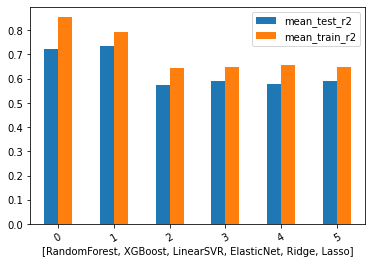

<IPython.core.display.Javascript object>

In [27]:
## Représentons maintenant les résultats que nous avons détaillé précédemment

## Dans un premier temps, les résultats pour la consommation énergétique.

r2 = ["mean_test_r2", "mean_train_r2"]
x = Energy_compare_metrics["level_0"]

Energy_compare_metrics[r2].plot(kind="bar", rot=30, xlabel=x)

<AxesSubplot:xlabel='[RandomForest, XGBoost, LinearSVR, ElasticNet, Ridge, Lasso]'>

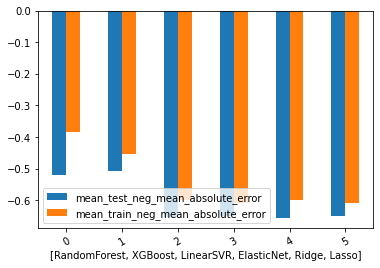

<IPython.core.display.Javascript object>

In [28]:
mae = ["mean_test_neg_mean_absolute_error", "mean_train_neg_mean_absolute_error"]
x = Energy_compare_metrics["level_0"]

Energy_compare_metrics[mae].plot(kind="bar", rot=30, xlabel=x)

<AxesSubplot:xlabel='[RandomForest, XGBoost, LinearSVR, ElasticNet, Ridge, Lasso]'>

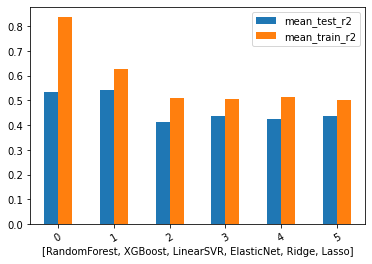

<IPython.core.display.Javascript object>

In [29]:
## Représentation pour les émissions de CO2

r2 = ["mean_test_r2", "mean_train_r2"]
x = Energy_compare_metrics["level_0"]

CO2_compare_metrics[r2].plot(kind="bar", rot=30, xlabel=x)

<AxesSubplot:xlabel='[RandomForest, XGBoost, LinearSVR, ElasticNet, Ridge, Lasso]'>

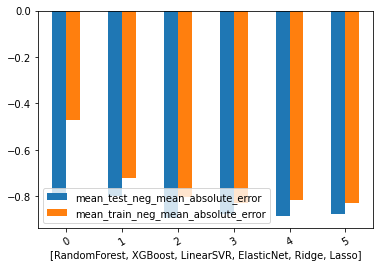

<IPython.core.display.Javascript object>

In [30]:
mae = ["mean_test_neg_mean_absolute_error", "mean_train_neg_mean_absolute_error"]
x = Energy_compare_metrics["level_0"]

CO2_compare_metrics[mae].plot(kind="bar", rot=30, xlabel=x)

## Partie 5 : Test des modéles sélectionnés 

In [31]:
## Je vais dans un premier temps récupéré l'importance des features. Ces données seront intéressantes lorsque nous testerons des
## améliorations du modéle.

coefficients_energy = abs(
    grid_energy.best_estimator_.named_steps.gbr.feature_importances_
)
liste_coefs_rer_energy = pd.DataFrame(coefficients_energy, columns=["Coefficients"])
coefficients_co2 = abs(grid_co2.best_estimator_.named_steps.gbr.feature_importances_)
liste_coefs_rer_co2 = pd.DataFrame(coefficients_co2, columns=["Coefficients"])

<IPython.core.display.Javascript object>

In [32]:
variable = pd.concat(
    (
        pd.DataFrame(data.loc[:, columns].columns, columns=["Variables"]),
        pd.DataFrame(enc.get_feature_names(), columns=["Variables"]),
    )
)

<IPython.core.display.Javascript object>

In [33]:
df_feature_importance_energy = pd.Series(coefficients_energy, index=variable)
df_feature_importance_co2 = pd.Series(coefficients_co2, index=variable)

<IPython.core.display.Javascript object>

In [34]:
df_feature_importance_energy.loc["BuildingType"] = df_feature_importance_energy.iloc[
    6:11
].sum(axis=0)
df_feature_importance_energy.loc["Neighborhood"] = df_feature_importance_energy.iloc[
    12:30
].sum(axis=0)
df_feature_importance_energy.loc[
    "LargestPropertyUseType"
] = df_feature_importance_energy.iloc[31:86].sum(axis=0)
df_feature_importance_energy.loc[
    "PrimaryPropertyType"
] = df_feature_importance_energy.iloc[87:110].sum(axis=0)

df_feature_importance_co2.loc["BuildingType"] = df_feature_importance_co2.iloc[
    6:11
].sum(axis=0)
df_feature_importance_co2.loc["Neighborhood"] = df_feature_importance_co2.iloc[
    12:30
].sum(axis=0)
df_feature_importance_co2.loc[
    "LargestPropertyUseType"
] = df_feature_importance_co2.iloc[31:86].sum(axis=0)
df_feature_importance_co2.loc["PrimaryPropertyType"] = df_feature_importance_co2.iloc[
    87:110
].sum(axis=0)

<IPython.core.display.Javascript object>

In [35]:
df_feature_importance_energy = df_feature_importance_energy.drop(
    index=df_feature_importance_energy.iloc[6:110].index
)

df_feature_importance_co2 = df_feature_importance_co2.drop(
    index=df_feature_importance_co2.iloc[6:110].index
)

<IPython.core.display.Javascript object>

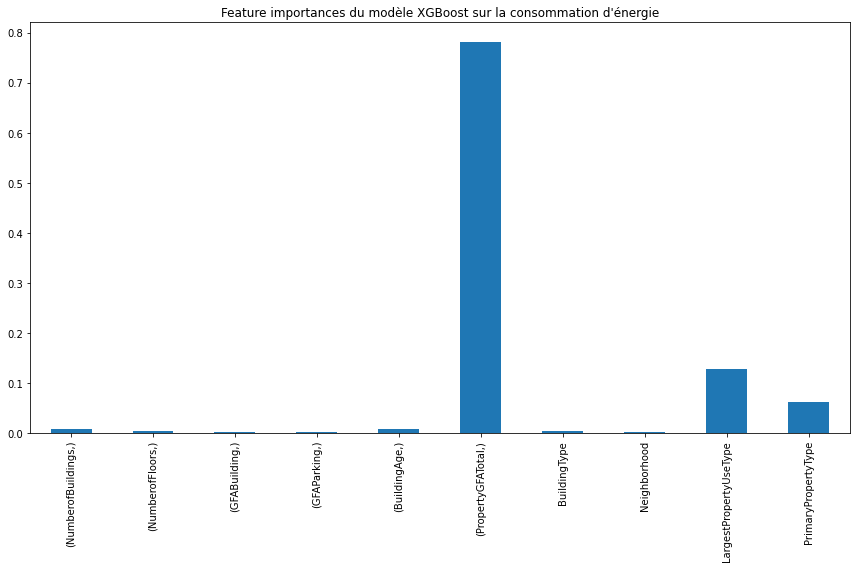

<IPython.core.display.Javascript object>

In [36]:
## Représentation pour l'énergie

fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importance_energy.plot.bar(ax=ax)
ax.set_title("Feature importances du modèle XGBoost sur la consommation d'énergie")
fig.tight_layout()

## Nous pouvons noter que les trois features importantes sont la surface et les utilisations du bâtiments
## Ceci peut nous donner un axe pour améliorer les performances du modéle en intégrant de nouvelles features proches de celle-ci

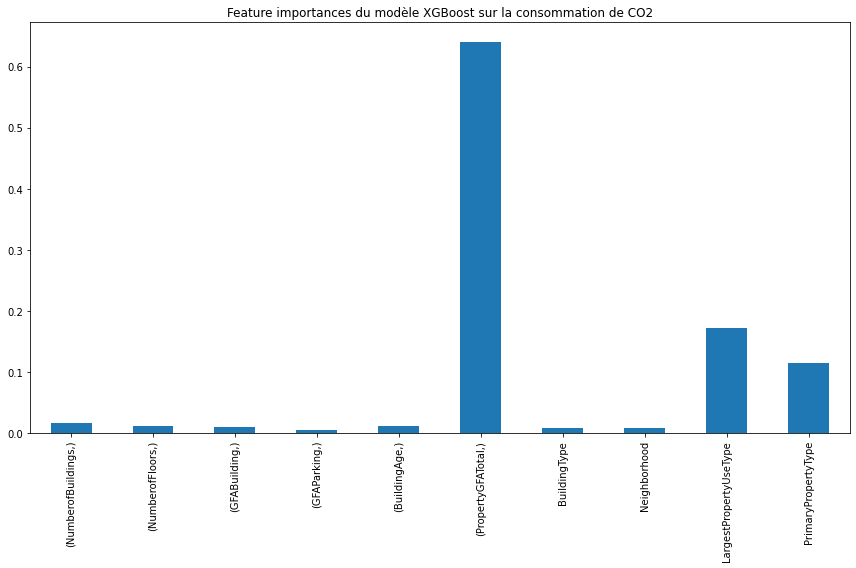

<IPython.core.display.Javascript object>

In [37]:
## Représentation pour les émissions de CO2

fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importance_co2.plot.bar(ax=ax)
ax.set_title("Feature importances du modèle XGBoost sur la consommation de CO2")
fig.tight_layout()

## Comme pour l'énergie, les features plus importantes sont la surface et les utilisations du bâtiments

In [38]:
## Nous allons maintenant passer à la partie où l'on test les modéles sur les données de test

## Test pour l'énergie

GBR_Energy.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

print(
    "r2 train :", r2_score(y_train["SiteEnergyUse(kBtu)"], GBR_Energy.predict(X_train))
)
print("r2 test :", r2_score(y_test["SiteEnergyUse(kBtu)"], GBR_Energy.predict(X_test)))

r2 train : 0.7872458107165097
r2 test : 0.7139458572735262


<IPython.core.display.Javascript object>

In [39]:
## Test pour le CO2

GBR_CO2.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])

print(
    "r2 train :",
    r2_score(y_train["GHGEmissions(MetricTonsCO2e)"], GBR_CO2.predict(X_train)),
)
print(
    "r2 test :",
    r2_score(y_test["GHGEmissions(MetricTonsCO2e)"], GBR_CO2.predict(X_test)),
)

r2 train : 0.6180502924109486
r2 test : 0.5202627787533665


<IPython.core.display.Javascript object>

In [40]:
## Je vais maintenant repasser mes données grâce à la transformation inverse. En effet, ce que nous voulons estimer, ce sont
## les données et non les données en logarithmes

y_train_true_energy = logtransformer.inverse_transform(y_train["SiteEnergyUse(kBtu)"])
y_test_true_energy = logtransformer.inverse_transform(y_test["SiteEnergyUse(kBtu)"])
x_train_true_energy = logtransformer.inverse_transform(GBR_Energy.predict(X_train))
x_test_true_energy = logtransformer.inverse_transform(GBR_Energy.predict(X_test))

y_train_true_co2 = logtransformer.inverse_transform(
    y_train["GHGEmissions(MetricTonsCO2e)"]
)
y_test_true_co2 = logtransformer.inverse_transform(
    y_test["GHGEmissions(MetricTonsCO2e)"]
)
x_train_true_co2 = logtransformer.inverse_transform(GBR_CO2.predict(X_train))
x_test_true_co2 = logtransformer.inverse_transform(GBR_CO2.predict(X_test))

<IPython.core.display.Javascript object>

In [41]:
## Test pour l'énergie

print('r2 test :' , r2_score(y_test_true_energy,x_test_true_energy))


r2 test : 0.7074398120741373


<IPython.core.display.Javascript object>

In [42]:
## Test pour les émissions de CO2

print("r2 test :", r2_score(y_test_true_co2, x_test_true_co2))

## On remarque que les performances ne sont pas affectées

r2 test : 0.529842699444947


<IPython.core.display.Javascript object>

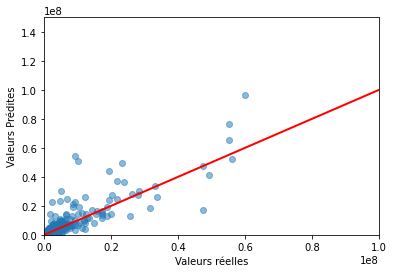

<IPython.core.display.Javascript object>

In [43]:
## Traçons maintenant les données prédites pour les comparé aux données réelles

## Pour l'énergie

plt.plot(x_test_true_energy,y_test_true_energy,'o',alpha=0.5)
plt.xlabel('Valeurs réelles')
plt.axis(xmin=0,ymin=0,xmax=1e8,ymax=1.5e8)
plt.ylabel('Valeurs Prédites')
plt.plot([0.0, 1e8], [0.0, 1e8], 'r-', lw=2)
plt.show()


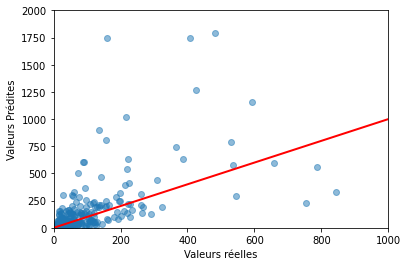

<IPython.core.display.Javascript object>

In [44]:
## Pour les émissions de CO2

plt.plot(x_test_true_co2, y_test_true_co2, "o", alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs Prédites")
plt.axis(xmin=0, ymin=0, xmax=1000, ymax=2000)
plt.plot([0.0, 2000], [0.0, 2000], "r-", lw=2)
plt.show()

## Partie 6 : Amélioration du modéle 

In [45]:
## Nous allons tester dans un premier temps, si l'utilisation de l'énergie StarScore, nous permet d'améliorer les performances
## du modéle.

## Preprocessing 

data_es = data[data['ENERGYSTARScore'].notna()]

columns = ['NumberofBuildings','NumberofFloors','GFABuilding','GFAParking','BuildingAge','PropertyGFATotal','ENERGYSTARScore']
mycolumns = ['BuildingType','Neighborhood','LargestPropertyUseType','PrimaryPropertyType'] 

X = data_es.loc[:,mycolumns]
enc.fit(X)
enc.transform(X)
enc.categories_
X_bis = enc.transform(X).todense()
f1_vec = data_es.loc[:,columns].values

X_2 = np.concatenate((f1_vec,X_bis),axis = 1)

donnees = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']

y = data_es.loc[:,donnees]

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_2, Y_log, test_size=0.2,  random_state=42)


<IPython.core.display.Javascript object>

In [46]:
pipe_gbr = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

param_gbr = {
    "gbr__n_estimators": [5, 10, 100, 500, 1000],
    "gbr__learning_rate": [0.01, 0.1, 0.2],
    "gbr__min_samples_split": [2, 4, 6],
    "gbr__min_samples_leaf": [1, 3, 10],
    "gbr__max_depth": [1, 5],
}

## Modéle pour l'énergie avec l'énergie Star Score

grid_energy_es = GridSearchCV(
    pipe_gbr,
    param_grid=param_gbr,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    cv=5,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)

grid_result = grid_energy_es.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

GBR_Energy_es = grid_energy_es.best_estimator_

Energy_results_gbr_es = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(
        Energy_results_gbr_es[Energy_results_gbr_es.rank_test_r2 == 1]["mean_test_r2"]
    ),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_gbr_es[Energy_results_gbr_es.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(
        Energy_results_gbr_es[Energy_results_gbr_es.rank_test_r2 == 1]["mean_fit_time"]
    ),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best R2:  [0.84905578]
Best MAE:  [-0.35597688]
Temps moyen [0.43847232] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 6, 'gbr__n_estimators': 500}


<IPython.core.display.Javascript object>

In [47]:
pipe_gbr = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

param_gbr = {
    "gbr__n_estimators": [5, 10, 100, 500],
    "gbr__learning_rate": [0.01, 0.1, 0.2, 0.3],
    "gbr__min_samples_split": [2, 6, 15, 20],
    "gbr__min_samples_leaf": [1, 5, 10],
    "gbr__max_depth": [1, 5, 10, 15],
}

## Modéle pour les émissions de CO2 avec l'énergie Star Score

grid_co2_es = GridSearchCV(
    pipe_gbr,
    param_grid=param_gbr,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    cv=5,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)

grid_result = grid_co2_es.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])

GBR_CO2_es = grid_co2_es.best_estimator_

CO2_results_gbr_es = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(CO2_results_gbr_es[CO2_results_gbr_es.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        CO2_results_gbr_es[CO2_results_gbr_es.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(CO2_results_gbr_es[CO2_results_gbr_es.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best R2:  [0.60250996]
Best MAE:  [-0.73060835]
Temps moyen [0.41944261] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 2, 'gbr__n_estimators': 500}


<IPython.core.display.Javascript object>

In [48]:
GBR_CO2_es.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])
GBR_Energy_es.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

## Je repasse les targets avec la fonction inverse

y_train_true_energy_es = logtransformer.inverse_transform(
    y_train["SiteEnergyUse(kBtu)"]
)
y_test_true_energy_es = logtransformer.inverse_transform(y_test["SiteEnergyUse(kBtu)"])
x_train_true_energy_es = logtransformer.inverse_transform(
    GBR_Energy_es.predict(X_train)
)
x_test_true_energy_es = logtransformer.inverse_transform(GBR_Energy_es.predict(X_test))

y_train_true_co2_es = logtransformer.inverse_transform(
    y_train["GHGEmissions(MetricTonsCO2e)"]
)
y_test_true_co2_es = logtransformer.inverse_transform(
    y_test["GHGEmissions(MetricTonsCO2e)"]
)
x_train_true_co2_es = logtransformer.inverse_transform(GBR_CO2_es.predict(X_train))
x_test_true_co2_es = logtransformer.inverse_transform(GBR_CO2_es.predict(X_test))

<IPython.core.display.Javascript object>

In [49]:
## Test des performances pour l'énergie

print(
    "r2 train :",
    r2_score(y_train["SiteEnergyUse(kBtu)"], GBR_Energy_es.predict(X_train)),
)
print(
    "r2 test :", r2_score(y_test["SiteEnergyUse(kBtu)"], GBR_Energy_es.predict(X_test))
)

## Les performances de nos prédictions avec l'énergie Starscore semblent meilleures.
## Il ne faut cependant pas oublier que cette variable était moins renseigné que les autres et le coût supplémentaire pour 
## pouvoir la déterminer.

r2 train : 0.8969972852661048
r2 test : 0.8666764935504276


<IPython.core.display.Javascript object>

In [50]:
print("r2 train :", r2_score(y_train_true_energy_es, x_train_true_energy_es))
print("r2 test :", r2_score(y_test_true_energy_es, x_test_true_energy_es))

r2 train : 0.7042059636029256
r2 test : 0.8970908368582337


<IPython.core.display.Javascript object>

In [51]:
## Test des perfomances pour le CO2

print(
    "r2 train :",
    r2_score(y_train["GHGEmissions(MetricTonsCO2e)"], GBR_CO2_es.predict(X_train)),
)
print(
    "r2 test :",
    r2_score(y_test["GHGEmissions(MetricTonsCO2e)"], GBR_CO2_es.predict(X_test)),
)

r2 train : 0.7017817304605993
r2 test : 0.6889057583867331


<IPython.core.display.Javascript object>

In [52]:
print("r2 train :", r2_score(y_train_true_co2_es, x_train_true_co2_es))
print("r2 test :", r2_score(y_test_true_co2_es, x_test_true_co2_es))

## Les performances de nos prédictions avec l'énergie Starscore semblent meilleures.
## Il ne faut cependant pas oublier que cette variable était moins renseigné que les autres et le coût supplémentaire pour 
## pouvoir la déterminer.

r2 train : 0.4878337909113356
r2 test : 0.696056438382576


<IPython.core.display.Javascript object>

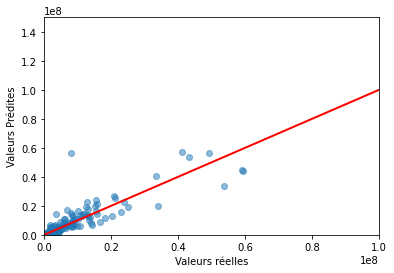

<IPython.core.display.Javascript object>

In [53]:
## Traçons maintenant les données prédites pour les comparé aux données réelles

plt.plot(x_test_true_energy_es, y_test_true_energy_es, "o", alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.axis(xmin=0, ymin=0, xmax=1e8, ymax=1.5e8)
plt.ylabel("Valeurs Prédites")
plt.plot([0.0, 1e8], [0.0, 1e8], "r-", lw=2)
plt.show()

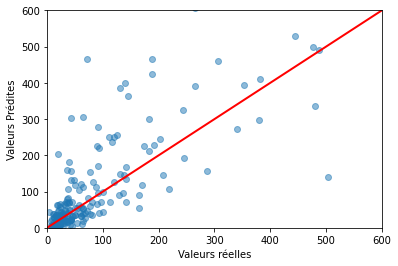

<IPython.core.display.Javascript object>

In [54]:
plt.plot(x_test_true_co2_es, y_test_true_co2_es, "o", alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs Prédites")
plt.axis(xmin=0, ymin=0, xmax=600, ymax=600)
plt.plot([0.0, 1000], [0.0, 1000], "r-", lw=2)
plt.show()

In [55]:
## On calcul les features importantes dans notre modéle avec EnergyStarScore pour visualiser l'importance de cette variable

coefficients_energy_es = abs(
    grid_energy_es.best_estimator_.named_steps.gbr.feature_importances_
)
liste_coefs_rer_energy_es = pd.DataFrame(
    coefficients_energy_es, columns=["Coefficients"]
)
coefficients_co2_es = abs(
    grid_co2_es.best_estimator_.named_steps.gbr.feature_importances_
)
liste_coefs_rer_co2_es = pd.DataFrame(coefficients_co2_es, columns=["Coefficients"])

variable = pd.concat(
    (
        pd.DataFrame(data.loc[:, columns].columns, columns=["Variables"]),
        pd.DataFrame(enc.get_feature_names(), columns=["Variables"]),
    )
)

df_feature_importance_energy_es = pd.Series(coefficients_energy_es, index=variable)
df_feature_importance_co2_es = pd.Series(coefficients_co2_es, index=variable)

df_feature_importance_energy_es.loc[
    "BuildingType"
] = df_feature_importance_energy_es.iloc[7:11].sum(axis=0)
df_feature_importance_energy_es.loc[
    "Neighborhood"
] = df_feature_importance_energy_es.iloc[12:29].sum(axis=0)
df_feature_importance_energy_es.loc[
    "LargestPropertyUseType"
] = df_feature_importance_energy_es.iloc[30:56].sum(axis=0)
df_feature_importance_energy_es.loc[
    "PrimaryPropertyType"
] = df_feature_importance_energy_es.iloc[57:77].sum(axis=0)

df_feature_importance_co2_es.loc["BuildingType"] = df_feature_importance_co2_es.iloc[
    7:11
].sum(axis=0)
df_feature_importance_co2_es.loc["Neighborhood"] = df_feature_importance_co2_es.iloc[
    12:29
].sum(axis=0)
df_feature_importance_co2_es.loc[
    "LargestPropertyUseType"
] = df_feature_importance_co2_es.iloc[30:56].sum(axis=0)
df_feature_importance_co2_es.loc[
    "PrimaryPropertyType"
] = df_feature_importance_co2_es.iloc[57:77].sum(axis=0)

df_feature_importance_energy_es = df_feature_importance_energy_es.drop(
    index=df_feature_importance_energy_es.iloc[7:77].index
)

df_feature_importance_co2_es = df_feature_importance_co2_es.drop(
    index=df_feature_importance_co2_es.iloc[7:77].index
)

<IPython.core.display.Javascript object>

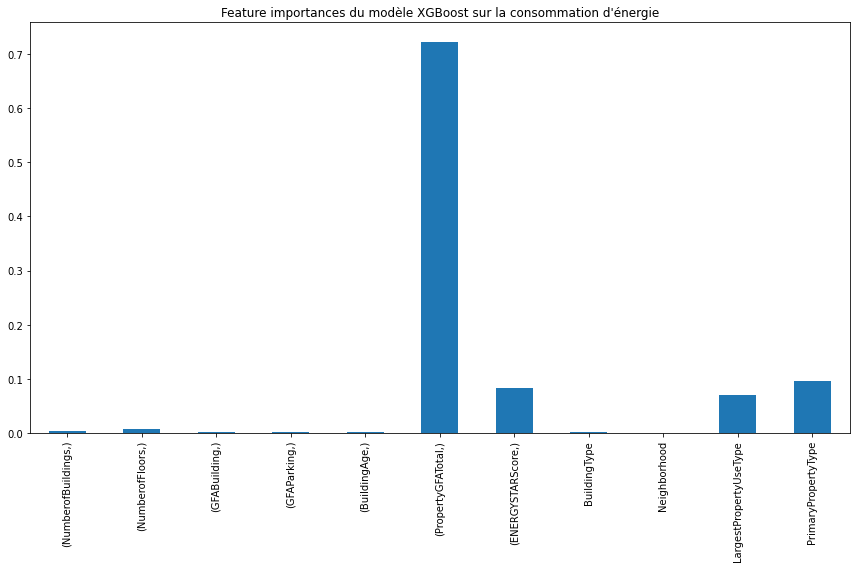

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importance_energy_es.plot.bar(ax=ax)
ax.set_title("Feature importances du modèle XGBoost sur la consommation d'énergie")
fig.tight_layout()

## On peut remarque que l'importance de l'énergy Star Score est au niveau des types de bâtiments pour l'énergie
## C'est assez logique avec l'amélioration des performances que l'on a pu constater.

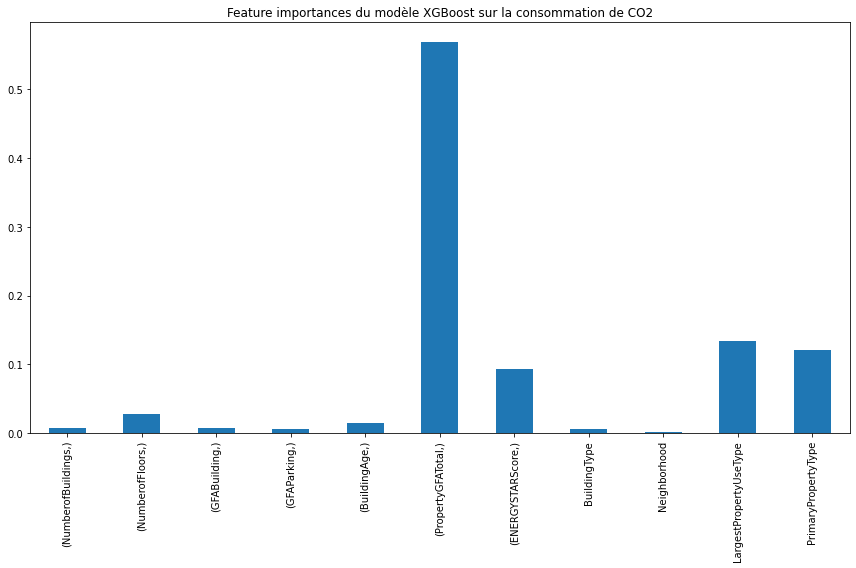

<IPython.core.display.Javascript object>

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importance_co2_es.plot.bar(ax=ax)
ax.set_title("Feature importances du modèle XGBoost sur la consommation de CO2")
fig.tight_layout()

## On peut remarque que l'importance de l'énergy Star Score est au niveau des types de bâtiments pour les émissions de CO2
## C'est assez logique avec l'amélioration des performances que l'on a pu constater.

In [58]:
## Je vais cette fois-ci, tester les modéles lorsque je garde toutes les données même les outliers et voir l'importance sur 
## les performances du modéle 

## Preprocessing

columns = ['NumberofBuildings','NumberofFloors','GFABuilding','GFAParking','BuildingAge','PropertyGFATotal']
mycolumns = ['BuildingType','Neighborhood','LargestPropertyUseType','PrimaryPropertyType'] 

X = data_wo.loc[:,mycolumns]
enc.fit(X)
enc.transform(X)
enc.categories_
X_bis = enc.transform(X).todense()
f1_vec = data_wo.loc[:,columns].values

X_2 = np.concatenate((f1_vec,X_bis),axis = 1)

donnees = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']

y = data_wo.loc[:,donnees]

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_2, Y_log, test_size=0.2, random_state=42)


<IPython.core.display.Javascript object>

In [59]:
pipe_gbr = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

param_gbr = {
    "gbr__n_estimators": [10, 100, 500, 1000],
    "gbr__learning_rate": [0.01, 0.1, 0.2],
    "gbr__min_samples_split": [2, 4, 6, 10],
    "gbr__min_samples_leaf": [1, 3, 10],
    "gbr__max_depth": [1, 5, 10],
}

## Modéle pour l'énergie

grid = GridSearchCV(
    pipe_gbr,
    param_grid=param_gbr,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    cv=5,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)

grid_result = grid.fit(X_train, y_train["SiteEnergyUse(kBtu)"])

GBR_Energy_wo = grid.best_estimator_

Energy_results_gbr_wo = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(
        Energy_results_gbr_wo[Energy_results_gbr_wo.rank_test_r2 == 1]["mean_test_r2"]
    ),
)
print(
    "Best MAE: ",
    np.array(
        Energy_results_gbr_wo[Energy_results_gbr_wo.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(
        Energy_results_gbr_wo[Energy_results_gbr_wo.rank_test_r2 == 1]["mean_fit_time"]
    ),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best R2:  [0.73498798]
Best MAE:  [-0.50895232]
Temps moyen [0.74301744] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 6, 'gbr__n_estimators': 500}


<IPython.core.display.Javascript object>

In [60]:
pipe_gbr = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

param_gbr = {
    "gbr__n_estimators": [10, 100, 500, 1000],
    "gbr__learning_rate": [0.01, 0.1, 0.2],
    "gbr__min_samples_split": [2, 6, 15, 20],
    "gbr__min_samples_leaf": [1, 5, 10],
    "gbr__max_depth": [1, 5, 10, 15],
}

## Modéle pour les émissions de CO2

grid = GridSearchCV(
    pipe_gbr,
    param_grid=param_gbr,
    scoring=("r2", "neg_mean_absolute_error"),
    return_train_score=True,
    cv=5,
    refit="r2",
    verbose=1,
    n_jobs=-1,
)

grid_result = grid.fit(X_train, y_train["GHGEmissions(MetricTonsCO2e)"])

GBR_CO2_wo = grid.best_estimator_

CO2_results_gbr_wo = pd.DataFrame.from_dict(grid_result.cv_results_)

print(
    "Best R2: ",
    np.array(CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1]["mean_test_r2"]),
)
print(
    "Best MAE: ",
    np.array(
        CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1][
            "mean_test_neg_mean_absolute_error"
        ]
    ),
)
print(
    "Temps moyen",
    np.array(CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1]["mean_fit_time"]),
    "s",
)
print("Best Params: ", grid_result.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best R2:  [0.54259665]
Best MAE:  [-0.79556149]
Temps moyen [1.59020824] s
Best Params:  {'gbr__learning_rate': 0.1, 'gbr__max_depth': 1, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 2, 'gbr__n_estimators': 500}


<ipython-input-60-d7eebd25fbac>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.array(CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1]["mean_test_r2"]),
<ipython-input-60-d7eebd25fbac>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1][
<ipython-input-60-d7eebd25fbac>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.array(CO2_results_gbr_wo[CO2_results_gbr_es.rank_test_r2 == 1]["mean_fit_time"]),


<IPython.core.display.Javascript object>

In [61]:
## Il semblerait pour les deux modéles que les performances sont moins bonnes lorsque l'on garde les outliers sur 
## les split de validations par rapport aux résultats avec l'énergy Star Score. Et les performances équivalentes sans outliers.

<IPython.core.display.Javascript object>

In [62]:
# On sauvegarde les différents estimateur

import pickle

Estimator = {
    "Ridge_Energy": Ridge_Energy,
    "Ridge_CO2": Ridge_CO2,
    "Lasso_Energy": Lasso_Energy,
    "Ridge_CO2": Lasso_CO2,
    "Elastic_Energy": Elastic_Energy,
    "Elastic_CO2": Elastic_CO2,
    "SVR_Energy": SVR_Energy,
    "SVR_CO2": SVR_CO2,
    "RandomForest_Energy": RFR_Energy,
    "RandomForest_CO2": RFR_CO2,
    "GradientBoosting_Energy": GBR_Energy,
    "GradientBoosting_CO2": GBR_CO2,
    "GradientBoosting_Energy_EnergyStarScore": GBR_Energy_es,
    "GradientBoosting_CO2_EnergyStarScore": GBR_CO2_es,
    "GradientBoosting_Energy_outlier": GBR_Energy_wo,
    "GradientBoosting_CO2_outlier": GBR_CO2_wo,
}
pickle.dump(Estimator, open("save.p", "wb"))

<IPython.core.display.Javascript object>

In [63]:
## Je créé une classe qui permet de retourner les estimations de la consommation énergétique et des émissions de CO2 en fonction
## de nouvelles données


class Energy_CO2_Predicteur:
    def __init__(self, OneHotEncoder, CO2_predicteur, Energy_predicteur):
        self.OneHotEncoder = OneHotEncoder
        self.CO2_predicteur = CO2_predicteur
        self.Energy_predicteur = Energy_predicteur

    def predicte_CO2_Energy(
        self,
        NumberofBuildings,
        NumberofFloors,
        GFABuilding,
        GFAParking,
        BuildingAge,
        PropertyGFATotal,
        ENERGYSTARScore,
        BuildingType,
        Neighborhood,
        LargestPropertyUseType,
        PrimaryPropertyType,
    ):
        x1 = np.array(
            [
                NumberofBuildings,
                NumberofFloors,
                GFABuilding,
                GFAParking,
                BuildingAge,
                PropertyGFATotal,
                ENERGYSTARScore,
            ]
        )
        x2 = self.OneHotEncoder.transform(
            [[BuildingType, Neighborhood, LargestPropertyUseType, PrimaryPropertyType]]
        )
        x2 = x2.todense()
        x2 = np.asarray(x2).reshape(-1)
        x = np.concatenate([x1, x2])
        x = x.reshape(1, x.shape[0])
        estimated_CO2 = self.CO2_predicteur.predict(x)
        estimated_energy = self.Energy_predicteur.predict(x)
        return dict(
            estimated_CO2=round(estimated_CO2[0], 2),
            estimated_energy=round(estimated_energy[0], 2),
        )

<IPython.core.display.Javascript object>

In [64]:
ecpredicteur = Energy_CO2_Predicteur(enc, GBR_CO2_es, GBR_Energy_es)

<IPython.core.display.Javascript object>